# Model training and predictions 
### Read from file and data cleaning

In [1]:
from pyspark.sql import SparkSession
spark  = SparkSession.builder.appName('App').config("spark.driver.memory", "14g").getOrCreate()

In [2]:
print(spark.sparkContext._conf.getAll())

[('spark.rdd.compress', 'True'), ('spark.app.name', 'App'), ('spark.serializer.objectStreamReset', '100'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.executor.id', 'driver'), ('spark.submit.deployMode', 'client'), ('spark.driver.memory', '14g'), ('spark.driver.host', '192.168.1.75'), ('spark.app.id', 'local-1607743322582'), ('spark.ui.showConsoleProgress', 'true'), ('spark.driver.port', '45127')]


In [2]:
""" NOTE: If prepared data exists, load it here: 
"""

test_df = spark.read.parquet("test_df_existing")
test_df = test_df.repartition(32)
train_df = spark.read.parquet("train_df_existing")
train_df = train_df.repartition(32)

In [2]:
# File location and type
file_location = "sample_train1.csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
multiline = "true"
escape = "\""

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.csv(file_location,
                  inferSchema = infer_schema, 
                  sep = delimiter, 
                  header = first_row_is_header, 
                  multiLine = multiline, 
                  escape = escape)
df = df.repartition(16)

In [4]:
df.show()

+-----+--------------------+--------------------+--------------+
|  _c0|                Body|               Title|           tag|
+-----+--------------------+--------------------+--------------+
| 8908|<p>how can we mat...|how to match non-...|           php|
|36618|<p><strong>Proble...|Issues with a ver...|         mysql|
|24904|<p>I have this si...|Any specific reas...|             c|
|97942|<p>I've been goog...|Calling a non sta...|       android|
|99214|<p>I'm using Wind...|How to turn off a...|     windows-8|
|25097|<p>Should I put a...|Add a txt file in...|       android|
| 8943|<p>Here's a simpl...|in Rails : Retrei...| ruby-on-rails|
|80683|<p>I am having lo...|$P[X=Y]=0$ if $X,...|measure-theory|
|55644|<p>my code is:</p...|Android Getting t...|       android|
|69229|<p>I'm trying to ...|How to properly u...|    sql-server|
|91002|<p>I am using the...|JQuery Birthday P...|    javascript|
|83853|<p>I am maintaini...|Am I confused abo...|            c#|
| 5540|<p>I have problem.

### Indexing tags in both test and train data sets

In [3]:
from pyspark.ml.feature import StringIndexer

#Encode tag's using String indexer

tag_idx = StringIndexer(inputCol='tag', outputCol = 'tag_idx')
tag_encode = tag_idx.fit(df)
df = tag_encode.transform(df)

In [6]:
df.count()

100060

# Preprocessing 

In [4]:
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_en = stopwords.words('english')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import RegexTokenizer

""" Helper functions for preprocessing. TODO: Consider wrapping into class below?
"""

@udf("String")
def lazy_prep_udf(c):
  """
  Clean noises from the string of text in given column

  Args:
    c - Column containing string of text

  Returns:
    Column with the cleaned string of text
  """
  df = BeautifulSoup(c)
  
  #noise
  urls = df.find_all('a')
  if urls != None:
    if len(urls)>0: 
      df.a.clear()
  
  return df.get_text().lower()

def tokenize(df, inputCol, outputCol):
  """
Split string of text in dataframe to word tokens.

Args:
  @param df Dataframe containing string of text
  @param inputCol name of input column containin the string of texts
  @param outputCol name of output column containin the word tokens
  
Returns:
  Dataframe containing the output column and the input column is dropped
"""
  tokenizer = RegexTokenizer(inputCol = inputCol, outputCol = outputCol, pattern=r"\s+") 
  df = tokenizer.transform(df).drop(inputCol)
  return df

def remove_punc(text):
  """Removes all punctuation marks from text.
  Args: 
    text (String): text column to convert 
  Returns:
    String.sql.Row: text w.o punctuation 
  """
  mod_punc = '!"$%&\'()*,-./:;<=>?@[\\]^_`{|}~'
  text = text.translate(str.maketrans(' ', ' ', mod_punc))
  return text.strip()


def remove_num(text):
  """Removes all numbers from text.
  Args: 
    text (String): text column to convert 
  Returns:
    String: text w.o numbers 
  """
  numbers="0123456789"
  text = text.translate(str.maketrans(' ', ' ', numbers))
  return text.strip()


  from nltk.tokenize import RegexpTokenizer 

@udf("String")
def trad_prep_udf(body):
  """Traditional body text preprocessing pieline. 
  Args: 
    text (pyspark.sql.Row): Text String to process
  Returns: 
    pyspark.sql.Row.ArrayType: cleaned tokens 
  """
  body = BeautifulSoup(body)
  stemmer = PorterStemmer()
  
  #noise
  urls = body.find_all('a')
  if len(urls)>0: 
    body.a.clear()
  
  text = body.get_text()
  
  words = []
  text = text.lower()

  tokenizer = RegexpTokenizer(r'\w+')
  # text = remove_punc(text)
  # text = remove_num(text)
  sents=tokenizer.tokenize(text)
  for sent in sents: 
    for word in nltk.word_tokenize(sent):
      if word in stop_en: continue
      # if len(word) < 3: continue
      words.append(stemmer.stem(word))
  return " ".join(words)


  """
Combine word tokens from title and body.

Args:
  df1 Dataframe containing Column with lists of stemmed word tokens from title
  inputCol1 name of the column containing lists of stemmed word tokens from title, cannot be same as inputCol2
  df2 Dataframe containing Column with lists of stemmed word tokens from body
  inputCol2 name of the column containing lists of stemmed word tokens from body, cannot be same as inputCol2
  outputCol column name of the ouput column containing the combined list of word tokens from title and body
"""
def combine_tokens(df, inputCol1, inputCol2, outputCol):
  result = df.withColumn(outputCol, concat(col(inputCol1), col(inputCol2)))
  return result

[nltk_data] Downloading package punkt to /home/mklasby/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mklasby/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
class Preprocessing:
  """Preprocessing stackoverflow question by remove html tags and tokenize words"""
  
  def __init__(self, df, titleCol, bodyCol):
    """
    Construct a Proprocessing object with attribute df: df cleans the text string in the given df using either lazy or traditional preprocessing
    """
    df = df.withColumn("Lazy_Title", lazy_prep_udf( df[titleCol] ) )
    df = df.withColumn("Lazy_Body", lazy_prep_udf( df[bodyCol] ) )
    df = df.withColumn("Trad_Title", trad_prep_udf( df[titleCol] ) )
    self.df = df.withColumn("Trad_Body", trad_prep_udf( df[bodyCol] ) )

  def get_token(self):
    self.df = tokenize(self.df, "Lazy_Title", 'Lazy_Title_Tokens')
    self.df = tokenize(self.df, "Lazy_Body", 'Lazy_Body_Tokens')
    self.df = tokenize(self.df, "Trad_Title", 'Trad_Title_Tokens')
    self.df = tokenize(self.df, "Trad_Body", 'Trad_Body_Tokens')
    return self.df

In [6]:
#Pre-processing the data
preProcessing = Preprocessing(df, "Title", "Body")
df_data = preProcessing.get_token()


In [7]:
from pyspark.sql.functions import desc, col

tag_counts = df.select('tag').groupby('tag').count().sort(desc('count'))
tag_counts.sort(col('count').desc()).show()

+-------------+-----+
|          tag|count|
+-------------+-----+
|           c#| 8541|
|         java| 7730|
|          php| 7175|
|   javascript| 6090|
|      android| 5214|
|          c++| 3635|
|       python| 3341|
|       iphone| 3257|
|       jquery| 3139|
|ruby-on-rails| 1925|
|      asp.net| 1791|
|        mysql| 1534|
|        linux| 1508|
|          sql| 1495|
|            c| 1388|
|         html| 1306|
|  objective-c| 1250|
|         .net| 1249|
|          ios| 1133|
|      windows|  922|
+-------------+-----+
only showing top 20 rows



In [7]:
body_counts = df_data.select('Trad_Body_Tokens').rdd.flatMap(lambda l : [(w,1) for w in l.Trad_Body_Tokens]).reduceByKey(lambda a,b: a+b).collect()
body_counts.sort(key=lambda tup: -tup[1])

In [11]:
display(body_counts[:10])

[('0', 102723),
 ('1', 99785),
 ('use', 91471),
 ('2', 56077),
 ('new', 52763),
 ('get', 52258),
 ('file', 52124),
 ('class', 49905),
 ('id', 47199),
 ('code', 46385)]

In [12]:
title_counts = df_data.select('Trad_Title_Tokens').rdd.flatMap(lambda l : [(w,1) for w in l.Trad_Title_Tokens]).reduceByKey(lambda a,b: a+b).collect()
title_counts.sort(key=lambda tup: -tup[1])

In [13]:
display(title_counts[:10])

[('use', 9812),
 ('file', 5485),
 ('c', 4653),
 ('get', 4166),
 ('jqueri', 3484),
 ('php', 3360),
 ('error', 3325),
 ('android', 3320),
 ('work', 3043),
 ('data', 2990)]

### Split test/train sets

In [ ]:
TRAINING_DATA_RATIO = 0.9
RANDOM_SEED = 1234

splits = [TRAINING_DATA_RATIO, 1.0 - TRAINING_DATA_RATIO]
training_data, test_data = df_data.randomSplit(splits, RANDOM_SEED)

In [ ]:
print("Number of training set rows: %d" % training_data.count())
print("Number of test set rows: %d" % test_data.count())

# Machine Learning Data Preparation

### Feature Engineering

In [12]:
from pyspark.ml.feature import CountVectorizer, IDF, NGram, VectorAssembler, StringIndexer, HashingTF
from pyspark.ml import Pipeline
def feature_engineer():
# FOR LAZY PRE-PROCESSING
  lazy_body_vector = CountVectorizer(inputCol = 'Lazy_Body_Tokens', outputCol = 'lazy_body_vector', minDF=0.01 , maxDF=0.85)
  lazy_title_vector = CountVectorizer(inputCol = 'Lazy_Title_Tokens', outputCol = 'lazy_title_vector', minDF=0.01 , maxDF=0.85)
  # FOR TRAD PRE-PROCESSING
  trad_body_vector = CountVectorizer(inputCol = 'Trad_Body_Tokens', outputCol = 'trad_body_vector', minDF=0.01 , maxDF=0.99)
  trad_title_vector = CountVectorizer(inputCol = 'Trad_Title_Tokens', outputCol = 'trad_title_vector', minDF=0.01 , maxDF=0.99)

  lazy_features = VectorAssembler(inputCols=['lazy_body_vector', 'lazy_title_vector'], outputCol='lazy_features')
  trad_features = VectorAssembler(inputCols=['trad_body_vector', 'trad_title_vector'], outputCol='trad_features')
  pipe = Pipeline(stages=[lazy_body_vector, lazy_title_vector, lazy_features, trad_body_vector, trad_title_vector, trad_features])
  pipe_model = pipe.fit(training_data)
  train_df = pipe_model.transform(training_data)  
  test_df = pipe_model.transform(test_data)
  return train_df, test_df

In [13]:
train_df, test_df = feature_engineer()

In [14]:
test_df.select("Trad_Body_Tokens", "trad_features", 'Body').show()

+--------------------+--------------------+--------------------+
|    Trad_Body_Tokens|       trad_features|                Body|
+--------------------+--------------------+--------------------+
|[ive, got, follow...|(968,[1,9,11,12,1...|<p>Ive got the fo...|
|[batch, file, ren...|(968,[0,1,4,5,6,1...|<p>Here is my bat...|
|[simpl, question,...|(968,[2,23,47,100...|<p>just a simple ...|
|[way, declar, sig...|(968,[2,35,38,42,...|<p>Is there a way...|
|[c, function, key...|(968,[15,19,27,33...|<p>I have in C# t...|
|[hi, develop, web...|(968,[5,11,12,13,...|<p>Hi i am develo...|
|[need, creat, tab...|(968,[0,1,3,8,16,...|<p>I need to crea...|
|[suppos, synchron...|(968,[2,4,5,6,11,...|<p>Suppose I'm sy...|
|[would, like, man...|(968,[11,18,26,60...|<p>I would like t...|
|[work, ajax, mome...|(968,[5,11,12,15,...|<p>I working with...|
|[c, exact, differ...|(968,[4,27,40,45,...|<p>in C++, what i...|
|[requir, display,...|(968,[2,15,57,59,...|<p>I have a requi...|
|[let, epsilon, ep...|(96

In [15]:
# write prepared files for further use
test_df.write.parquet("test_df_existing")
train_df.write.parquet("train_df_existing")

# Model Training

## Metrics helper

In [4]:
from pyspark.mllib.evaluation import MulticlassMetrics


def print_metrics(results_df, by_tag = False, ground_truth_col='tag_idx', prediction_col='prediction'):
    labels_and_predictions = results_df.select([ground_truth_col, prediction_col])
    # Instantiate metrics object
    metrics = MulticlassMetrics(labels_and_predictions.rdd)
    # Overall statistics
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)
    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

    if by_tag: 
        # Statistics by class
        labels = df.rdd.map(lambda lp: lp.tag_idx).distinct().collect()
        # print(labels)
        for label in sorted(labels):
            try:
                print("Class %s precision = %s" % (label, metrics.precision(label)))
                print("Class %s recall = %s" % (label, metrics.recall(label)))
                print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
            except: 
                print("Class %s not in this set!" % (label))

## Logistic Regression

**Hyperparameter Tuning**

In [4]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import IndexToString


lr = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx")

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0, 0.1, 1.0]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

lr_tvs = TrainValidationSplit(estimator=lr, 
                          estimatorParamMaps=paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='tag_idx'), 
                          trainRatio=0.9, 
                          seed=0
                         )

lr_grid_search = lr_tvs.fit(train_df)

In [5]:
print('Best Param (regParam): ', lr_grid_search.bestModel._java_obj.getRegParam())
print('Best Param (elasticNetParam): ', lr_grid_search.bestModel._java_obj.getElasticNetParam())
print('Best Param (fitIntercept): ', lr_grid_search.bestModel._java_obj.getFitIntercept())

Best Param (regParam):  0.0
Best Param (elasticNetParam):  0.0
Best Param (fitIntercept):  False


In [6]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import IndexToString


lr = LogisticRegression(featuresCol = "lazy_features", labelCol = "tag_idx")

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0, 0.1, 1.0]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

lr_tvs = TrainValidationSplit(estimator=lr, 
                          estimatorParamMaps=paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='tag_idx'), 
                          trainRatio=0.9, 
                          seed=0
                         )

lr_lazy_grid_search = lr_tvs.fit(train_df)

In [7]:
print('Best Param (regParam): ', lr_lazy_grid_search.bestModel._java_obj.getRegParam())
print('Best Param (elasticNetParam): ', lr_lazy_grid_search.bestModel._java_obj.getElasticNetParam())
print('Best Param (fitIntercept): ', lr_lazy_grid_search.bestModel._java_obj.getFitIntercept())

Best Param (regParam):  0.0
Best Param (elasticNetParam):  0.0
Best Param (fitIntercept):  False


**Model training and transformation of test set**

In [3]:
from pyspark.ml.classification import LogisticRegression
# Lazy model
lr_lazy = LogisticRegression(featuresCol = "lazy_features", labelCol = "tag_idx", fitIntercept=False, elasticNetParam=0, regParam=0)
lr_lazy_model = lr_lazy.fit(train_df)
lr_lazy_results = lr_lazy_model.transform(test_df)

In [9]:
from pyspark.ml.classification import LogisticRegression
# Trad model
lr_trad = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx", fitIntercept=False, elasticNetParam=0.0, regParam=0)
lr_trad_model = lr_trad.fit(train_df)
lr_trad_results = lr_trad_model.transform(test_df)

**Performance Metrics**

In [8]:
# Lazy metrics
# lr_lazy = LogisticRegression(featuresCol = "lazy_features", labelCol = "tag_idx", fitIntercept=False, elasticNetParam=0.0, regParam=0)
print_metrics(lr_lazy_results)

Summary Stats
Precision = 0.49489795918367346
Recall = 0.5344352617079889
F1 Score = 0.5139072847682119
Weighted recall = 0.35045742434905025
Weighted precision = 0.35655666236661515
Weighted F(1) Score = 0.3507803305779452
Weighted F(0.5) Score = 0.3534107173080045
Weighted false positive rate = 0.017121376605129898


In [10]:
# Trad Metrics
#lr_trad = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx", fitIntercept=False, elasticNetParam=0.0, regParam=0)
print_metrics(lr_trad_results)

Summary Stats
Precision = 0.5357142857142857
Recall = 0.56
F1 Score = 0.547588005215124
Weighted recall = 0.38212526389866314
Weighted precision = 0.3877690581431736
Weighted F(1) Score = 0.3824640837548646
Weighted F(0.5) Score = 0.38494784668869075
Weighted false positive rate = 0.016424941638840743


## Naive Bayes Classification

**Hyperparameter Tuning**

In [11]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import IndexToString

nb = NaiveBayes(featuresCol = "trad_features", labelCol = "tag_idx", modelType="multinomial")

paramGrid = ParamGridBuilder()\
    .addGrid(nb.smoothing, [0.01, 0.1, 0.5, 1.0, 10.0, 100.0]) \
    .build()

nb_tvs = TrainValidationSplit(estimator=nb, 
                          estimatorParamMaps=paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='tag_idx'), 
                          trainRatio=0.9, 
                          seed=0
                         )

nb_grid_search = nb_tvs.fit(train_df)

In [11]:
print('Best Param (smoothing): ', nb_grid_search.bestModel._java_obj.getSmoothing())

Best Param (smoothing):  0.01


**Model training and transformation of test set**

In [11]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import IndexToString


# Lazy Model
# TODO: Select best hyper parameters
nb_lazy = NaiveBayes(featuresCol = "lazy_features", labelCol = "tag_idx", modelType="multinomial", smoothing=0.01)
nb_lazy_model = nb_lazy.fit(train_df)
nb_lazy_result = nb_lazy_model.transform(test_df)

In [13]:
# Trad Model
# TODO: Select best hyper parameters
nb_trad = NaiveBayes(featuresCol = "trad_features", labelCol = "tag_idx", modelType="multinomial", smoothing=0.01)
nb_trad_model = nb_trad.fit(train_df)
nb_trad_result = nb_trad_model.transform(test_df)

**Performance Metrics**

In [12]:
# Lazy Metrics
print_metrics(nb_lazy_result)

Summary Stats
Precision = 0.22576530612244897
Recall = 0.6755725190839694
F1 Score = 0.3384321223709369
Weighted recall = 0.2816929727556047
Weighted precision = 0.2778043273410249
Weighted F(1) Score = 0.2539449949268157
Weighted F(0.5) Score = 0.25845398417212156
Weighted false positive rate = 0.01353781411707201


In [14]:
# Trad Metrics
print_metrics(nb_trad_result)

Summary Stats
Precision = 0.28316326530612246
Recall = 0.7138263665594855
F1 Score = 0.4054794520547945
Weighted recall = 0.3141650748969543
Weighted precision = 0.3276984683655164
Weighted F(1) Score = 0.28934060344649265
Weighted F(0.5) Score = 0.2996296956205349
Weighted false positive rate = 0.0134165456481436


##Random Forest

**Hyperparameter Tuning**

In [18]:
#Random Forest Classification
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(featuresCol = "trad_features", labelCol = "tag_idx")

paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10,15]) \
    .addGrid(rf.maxDepth, [10,15,20])\
    .build()

rf_tvs = TrainValidationSplit(estimator=rf, 
                          estimatorParamMaps=paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='tag_idx'), 
                          trainRatio=0.9
                         )
rf_grid_search = rf_tvs.fit(train_df)

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 48206)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/mklasby/miniconda3/envs/ensf-ml/lib/python3.8/site-packages/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mklasby/miniconda3/envs/ensf-ml/lib/python3.8/site-packages/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/home/mklasby/miniconda3/envs/ensf-ml/lib/python3.8/site-packages/py4j/java_gateway.py", line 1211, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving
Traceback (most recent call last):
ERROR:py4j.java_gateway:An error occurre

Py4JError: An error occurred while calling o1487.fit

In [ ]:
print('Best Param (regParam): ', rf_grid_search.bestModel._java_obj.getNumTrees())
print('Best Param (elasticNetParam): ', rf_grid_search.bestModel._java_obj.getMaxDepth())

**Model training and transformation of test set**

In [4]:
#Random Forest Classification
from pyspark.ml.classification import RandomForestClassifier

#Lazy Model
# TODO: Select best hyper parameters
rf_lazy = RandomForestClassifier(featuresCol = "lazy_features", labelCol = "tag_idx", maxDepth=15, numTrees=15)
rf_model_lazy = rf_lazy.fit(train_df)
rf_lazy_results = rf_model_lazy.transform(test_df)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/mklasby/miniconda3/envs/ensf-ml/lib/python3.8/site-packages/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mklasby/miniconda3/envs/ensf-ml/lib/python3.8/site-packages/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/home/mklasby/miniconda3/envs/ensf-ml/lib/python3.8/site-packages/py4j/java_gateway.py", line 1211, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:39065)
Traceback (most recent call last):
  File "/home/mklasby/miniconda3/envs/ensf-ml/lib/py

Py4JError: An error occurred while calling o40.fit

In [4]:
#Random Forest Classification
from pyspark.ml.classification import RandomForestClassifier

#Lazy Model
# TODO: Select best hyper parameters
rf_lazy = RandomForestClassifier(featuresCol = "lazy_features", labelCol = "tag_idx", maxDepth=15, numTrees=10)
rf_model_lazy = rf_lazy.fit(train_df)
rf_lazy_results = rf_model_lazy.transform(test_df)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/mklasby/miniconda3/envs/ensf-ml/lib/python3.8/site-packages/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mklasby/miniconda3/envs/ensf-ml/lib/python3.8/site-packages/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/home/mklasby/miniconda3/envs/ensf-ml/lib/python3.8/site-packages/py4j/java_gateway.py", line 1211, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while receiving
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:41691)
Traceback (most recent call last):
  File "/home/mklasby/miniconda3/envs/ensf-ml/lib/py

Py4JError: An error occurred while calling o40.fit

In [3]:
#Random Forest Classification
from pyspark.ml.classification import RandomForestClassifier

#Lazy Model
# TODO: Select best hyper parameters
rf_lazy = RandomForestClassifier(featuresCol = "lazy_features", labelCol = "tag_idx", maxDepth=10, numTrees=10)
rf_model_lazy = rf_lazy.fit(train_df)
rf_lazy_results = rf_model_lazy.transform(test_df)

In [3]:
from pyspark.ml.classification import RandomForestClassifier
# Trad Model
# TODO: Select best hyper parameters
rf_trad = RandomForestClassifier(featuresCol = "trad_features", labelCol = "tag_idx", maxDepth=20, numTrees=15)
rf_trad_model = rf_trad.fit(train_df)
rf_trad_result = rf_trad_model.transform(test_df)

**Performance Metrics**

In [6]:
# Lazy Metrics 10x10
print_metrics(rf_lazy_results)

Summary Stats
Precision = 0.45918367346938777
Recall = 0.6642066420664207
F1 Score = 0.5429864253393666
Weighted recall = 0.30511712073992153
Weighted precision = 0.7663697993913352
Weighted F(1) Score = 0.34100228797218113
Weighted F(0.5) Score = 0.4475961658698829
Weighted false positive rate = 0.02480785040176927


In [6]:
# Trad Metrics 20x15
print_metrics(rf_trad_result)

Summary Stats
Precision = 0.6147959183673469
Recall = 0.6657458563535912
F1 Score = 0.6392572944297082
Weighted recall = 0.40816326530612257
Weighted precision = 0.731501419381625
Weighted F(1) Score = 0.46347084656339144
Weighted F(0.5) Score = 0.5557981601382896
Weighted false positive rate = 0.01890338071412559


##SVC + OVR
Due to limited nodes included in the databricks community edition, we were unable to fit a one-vs-rest model with a support-vector-classifier in under 3 hours. Therefore, we recommend future researchers consider investing is a full fledged account to test this model type on large datasets.

In [18]:
# Do not run!
# TESTED OVER NIGHT, DID NOT COMPLETE FIT IN MORE THAN 12 HOURS
from pyspark.ml.classification import LinearSVC, OneVsRest
svc = LinearSVC(featuresCol = "trad_features", labelCol = "tag_idx")
ovr = OneVsRest(featuresCol = "trad_features", labelCol = "tag_idx",  classifier= svc)
ovrModel = ovr.fit(train_df)
svc_result = ovrModel.transform(test_df)

KeyboardInterrupt: 

In [ ]:
# Trad Metrics

#Get labels/predictions in RDD expected by metrics classes
svc_trad_labels_and_predictions = svc_result.select(["tag_idx", "prediction"])

# Instantiate metrics object
svc_trad_metrics = MulticlassMetrics(svc_trad_labels_and_predictions.rdd)

# Weighted stats
print("Weighted recall = %s" % svc_trad_metrics.weightedRecall)
print("Weighted precision = %s" % svc_trad_metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % svc_trad_metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % svc_trad_metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % svc_trad_metrics.weightedFalsePositiveRate)

# Results Analysis
As we can see from the above, the __ and __ model performed best on the lazy features and traditional features, respectively. We will now use the __ model to determine the highest performing and lowest performing classes.

In [7]:
# TODO: Update with best performing model 
top_df = rf_trad_result
top_df.show()

+-----+--------------------+--------------------+-------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  _c0|                Body|               Title|                tag|tag_idx|   Lazy_Title_Tokens|    Lazy_Body_Tokens|   Trad_Title_Tokens|    Trad_Body_Tokens|    lazy_body_vector|   lazy_title_vector|       lazy_features|    trad_body_vector|   trad_title_vector|       trad_features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+-------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------

In [8]:
# write prepared file for further use
top_df.write.parquet("top_df_existing")

In [14]:
top_df = spark.read.parquet("top_df_existing")
top_df.cache()
top_df.count()

9947

In [15]:
from pyspark.ml.feature import IndexToString
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer

#Encode tag's using String indexer
decoder = IndexToString(inputCol="prediction", outputCol="predicted_tag", labels=tag_encode.labels)
top_df = decoder.transform(top_df)

In [16]:
top_df.select(["tag", "tag_idx", "prediction", "predicted_tag"]).show()

+----------------+-------+----------+-------------+
|             tag|tag_idx|prediction|predicted_tag|
+----------------+-------+----------+-------------+
|            java|    1.0|       1.0|         java|
|     objective-c|   16.0|       7.0|       iphone|
|             php|    2.0|       2.0|          php|
|               c|   14.0|       5.0|          c++|
|         android|    4.0|       4.0|      android|
|         windows|   19.0|      21.0|    windows-7|
|          c#-4.0|  186.0|       4.0|      android|
|       wordpress|   54.0|       2.0|          php|
|      javascript|    3.0|       0.0|           c#|
|           regex|   34.0|       0.0|           c#|
|              c#|    0.0|       0.0|           c#|
|             wcf|   51.0|       0.0|           c#|
|          macosx|  379.0|       0.0|           c#|
|              c#|    0.0|       5.0|          c++|
|          vb.net|   30.0|       0.0|           c#|
|               r|   27.0|       0.0|           c#|
|           

In [90]:
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd


def get_label_metrics(results_df, ground_truth_col='tag_idx', prediction_col='prediction'):
    """Get pandas dataframe of top 10 tags with metrics from top_df

    Params: 
        results_df (pyspark DataFrame): top_df to get metrics of

    Returns:
        (pd.DataFrame): pandas dataframe in form of {column: [row_data]} for plotting
    """
    labels_and_predictions = results_df.select([ground_truth_col, prediction_col])
    # Instantiate metrics object
    metrics = MulticlassMetrics(labels_and_predictions.rdd)

    #get dict of labels to plot
    label_metrics = {}

    # Statistics by class
    labels = df.rdd.map(lambda lp: lp.tag_idx).distinct().collect()
    # print(labels)
    for label in sorted(labels):
        prec_recall_fMeasure = ()
        try:
            prec = metrics.precision(label)
            recall = metrics.recall(label)
            fMeasure = metrics.fMeasure(label, beta=1.0)
            prec_recall_fMeasure = (fMeasure, prec, recall) 
            label_metrics[label] = prec_recall_fMeasure
        except: 
            label_metrics[label] = (0,0,0)

    # get tags in string form: 
    tags = results_df.select(['tag', 'tag_idx']).distinct().collect()
    tag_pairs = {x['tag_idx']: x['tag'] for x in tags}

    # Convert tag classes into strings 
    tag_metrics = {}
    for tag_index in tag_pairs: 
        tag_metrics[tag_pairs[tag_index]] = label_metrics[tag_index]

    # Top 10 tags
    top_10_tags = sorted(tag_metrics, key=lambda x: tag_metrics[x][0], reverse=True)[:10]

    # Get ready for plotting
    plot_dict = {}
    tag_list = []
    f1_list = []
    precision_list = []
    recall_list = []

    for tag in top_10_tags:
        tag_list.append(tag)
        f1_list.append(tag_metrics[tag][0])
        precision_list.append(tag_metrics[tag][1])
        recall_list.append(tag_metrics[tag][2])

    plot_df = pd.DataFrame({"Tag": tag_list, "F1Measure": f1_list, "Precision":precision_list, "Recall":recall_list})
    
    return plot_df

In [91]:
plot_df = get_label_metrics(top_df)
print(plot_df)

             Tag  F1Measure  Precision    Recall
0        android   0.770833   0.811700  0.733884
1         python   0.742301   0.755776  0.729299
2            php   0.704331   0.765348  0.652326
3  ruby-on-rails   0.688000   0.728814  0.651515
4           java   0.639257   0.614796  0.665746
5          mysql   0.624204   0.640523  0.608696
6         iphone   0.617284   0.679758  0.565327
7         jquery   0.613372   0.639394  0.589385
8     javascript   0.534680   0.651888  0.453196
9            c++   0.520124   0.471910  0.579310


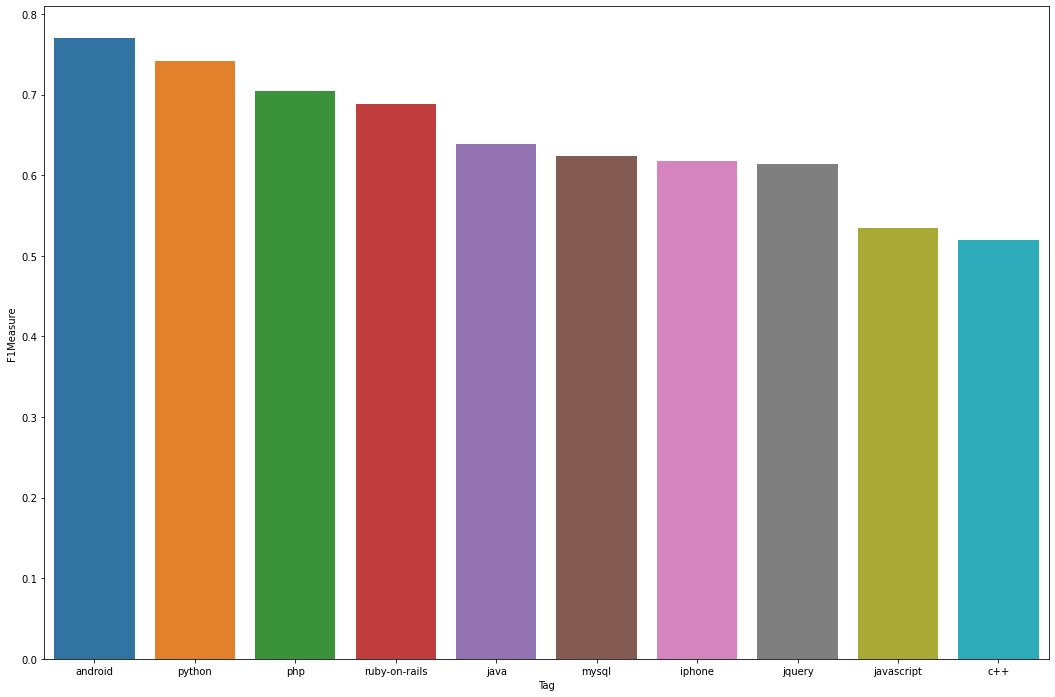

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="F1Measure", data=plot_df, ax=ax)
fig.show()

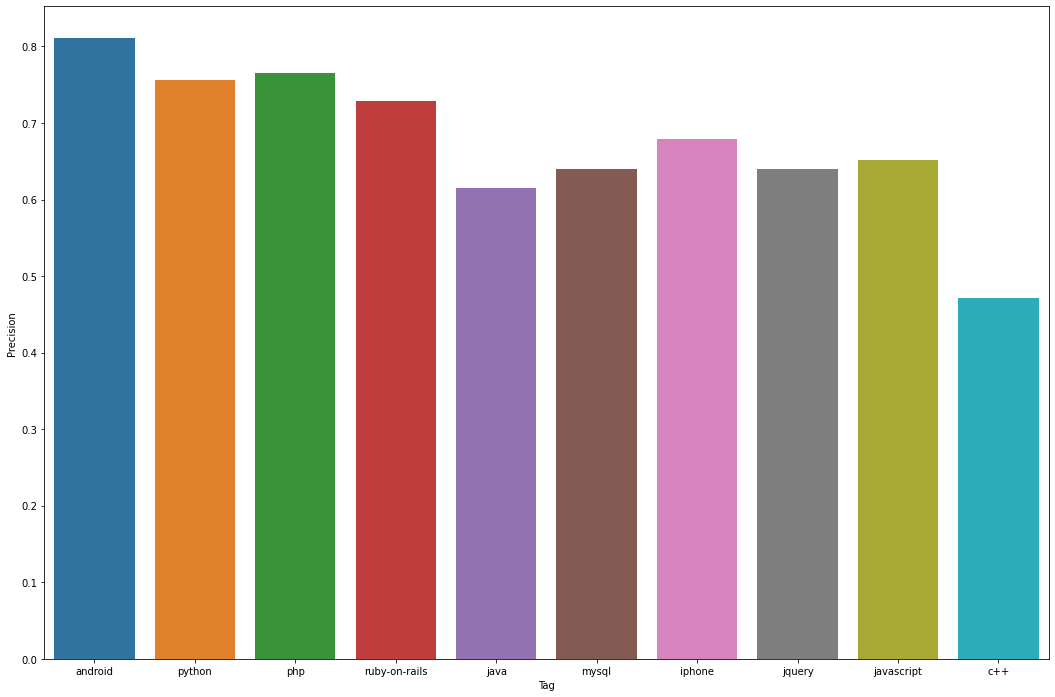

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Precision", data=plot_df, ax=ax)
fig.show()

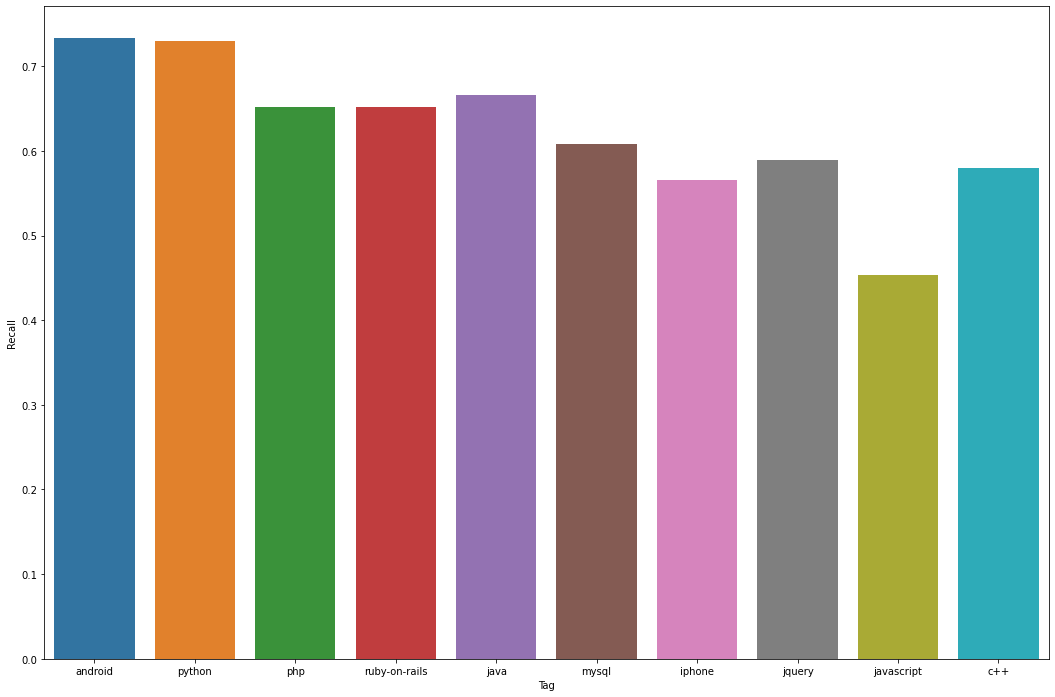

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Recall", data=plot_df, ax=ax)
fig.show()

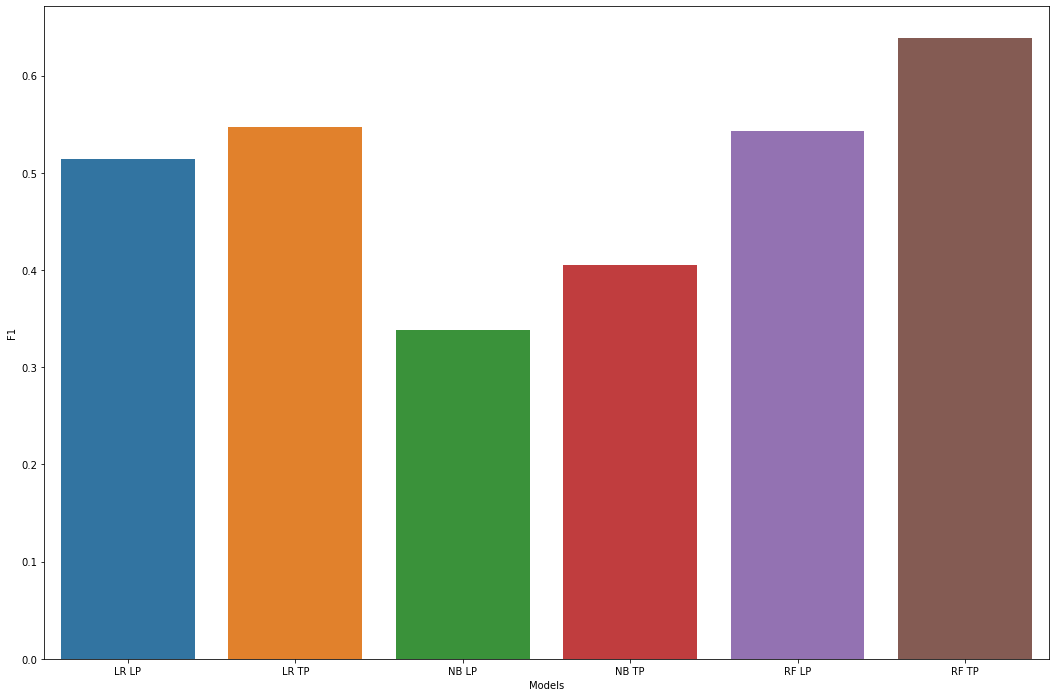

In [102]:
# F1 Weighted Results 
# TODO: Update f1 scores below 

lr_lazy = 0.5139072847682119
lr_trad = 0.547588005215124
nb_lazy = 0.3384321223709369
nb_trad = 0.4054794520547945
rf_lazy= 0.5429864253393666
rf_trad = 0.6392572944297082
this_dict = {'Models': ["LR LP","LR TP", "NB LP", "NB TP", "RF LP", "RF TP"], "F1": [lr_lazy, lr_trad, nb_lazy, nb_trad, rf_lazy,rf_trad]}

seaborn_df = pd.DataFrame.from_dict(this_dict)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Models", y="F1", data=seaborn_df, ax =ax)
fig.show()